# Neuro-Nav Usage Tutorial

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.grid_env import GridEnv, GridSize, GridObsType, OrientationType
from neuronav.envs.graph_env import GraphEnv
from neuronav.agents.td_agents import TDSR, TDQ
from neuronav.envs.grid_topographies import GridTopography
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

## Using the `GridEnv`

For information on supported environment topographies and observation spaces, see [here](https://github.com/awjuliani/neuro-nav/tree/main/neuronav/envs#gridenv).

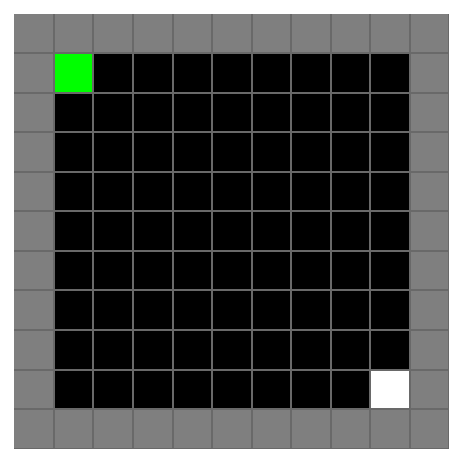

In [3]:
env = GridEnv()
obs = env.reset()
env.render()

`GridEnv` follows the OpenAI Gym interface API. We can act in the environment by calling `env.step(action)`. Here we pass action `0` which corresponds to moving a step upward in the grid environment.

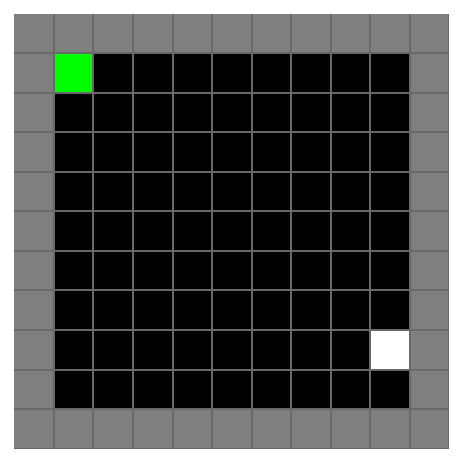

In [4]:
obs, reward, done, _ = env.step(0)
env.render()

### Selecting a different grid topography

Topographies can be selected by passing a `GridTopography` enum as an argument when creating the `GridEnv` object. Here we create the classic four rooms environment.

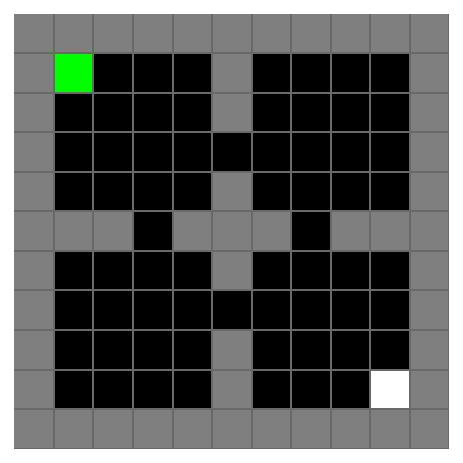

In [5]:
env = GridEnv(topography=GridTopography.four_rooms)
obs = env.reset()
env.render()

It is also possible to select either the `small` or `large` variant of each topography using the `GridSize` enum.

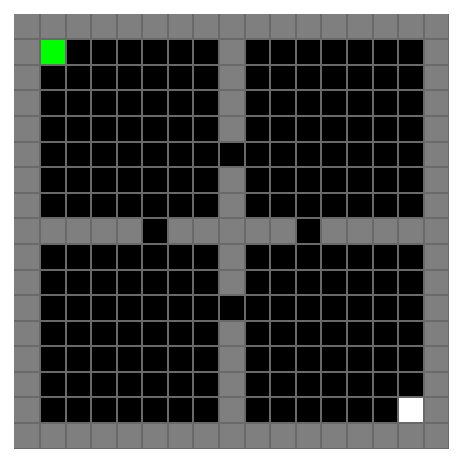

In [6]:
env = GridEnv(topography=GridTopography.four_rooms, grid_size=GridSize.large)
obs = env.reset()
env.render()

### Selecting a different observation type

Various different observation spaces can be used with `GridEnv` by passing the `GridObsType` enum when creating the `GridEnv` object. Here we use the `window` observation type, which provides a 5 x 5 local window around the agent as the observation.

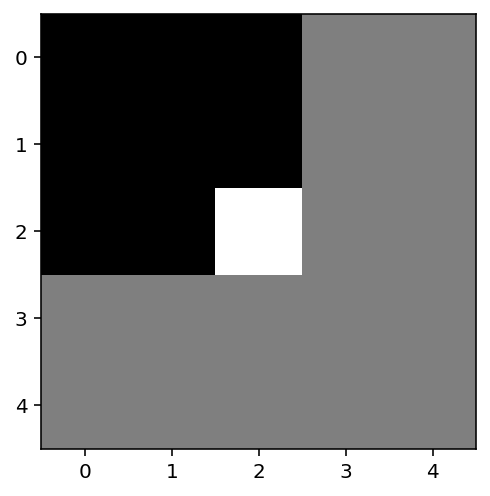

In [7]:
env = GridEnv(obs_type=GridObsType.window)
obs = env.reset()
plt.imshow(obs)

### Selecting dynamic orientation

`GridEnv` also supports a dynamic orientation for the agent. This can be selected with the `OrientationType.dynamic` enum.

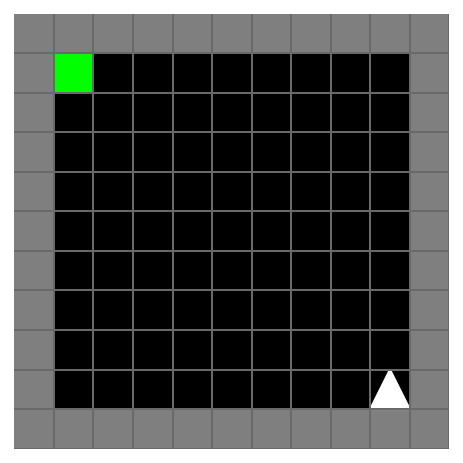

In [8]:
env = GridEnv(orientation_type=OrientationType.dynamic)
obs = env.reset()
env.render()

With the `dynamic` orientation type, the action space consists of a forward movement action, and 90 degree rotation actions either clockwise or counter clockwise.

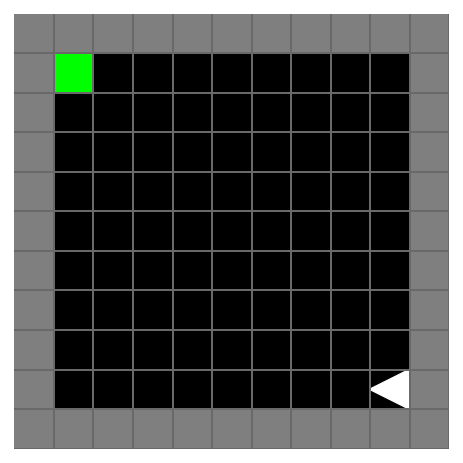

In [9]:
obs, reward, done, _ = env.step(0)
env.render()

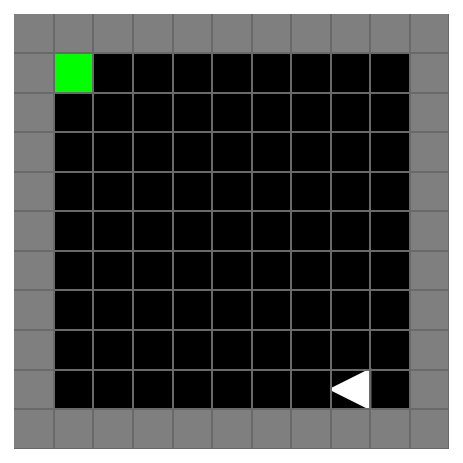

In [10]:
env.step(2)
env.render()

### Training an agent to reach the goal

Neuro-Nav includes a number of cannonical RL algorithms. Here we create an agent using the `TDSR` algorithm (Temporal Different Successor Representation), and solve a simple goal-directed navigation task.

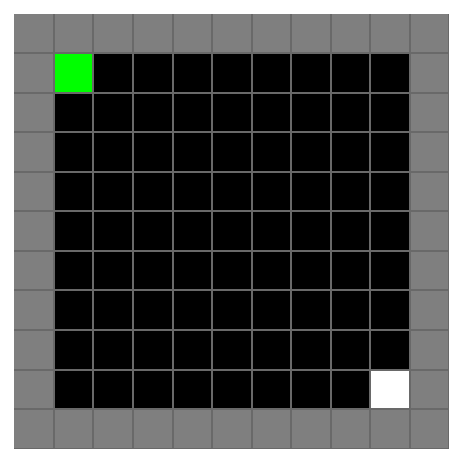

In [11]:
num_episodes = 300
num_steps = 100

env = GridEnv(
    topography=GridTopography.empty,
    grid_size=GridSize.small,
    obs_type=GridObsType.index,
    orientation_type=OrientationType.fixed,
)
obs = env.reset()
env.render()

agent = TDSR(
    env.state_size,
    env.action_space.n,
    lr=1e-1,
    poltype="egreedy",
    epsilon=0.2,
    gamma=0.9,
)

Text(0, 0.5, 'Time-steps')

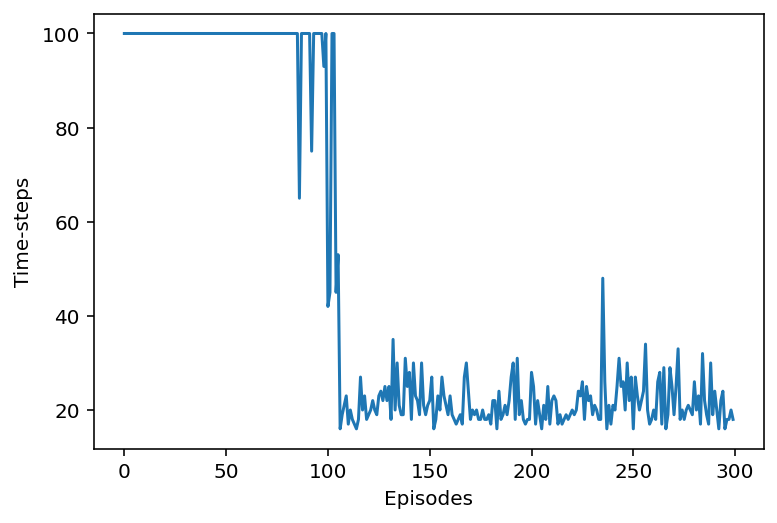

In [12]:
total_steps = []
for i in range(num_episodes):
    obs = env.reset()
    steps = 0
    done = False
    while not done and steps < num_steps:
        act = agent.sample_action(obs)
        obs_new, reward, done, _ = env.step(act)
        agent.update([obs, act, obs_new, reward, done])
        obs = obs_new
        steps += 1
    total_steps.append(steps)
plt.plot(total_steps)
plt.xlabel("Episodes")
plt.ylabel("Time-steps")

Neuro-Nav also provides a simple helper function for running episodes.

Text(0, 0.5, 'Time-steps')

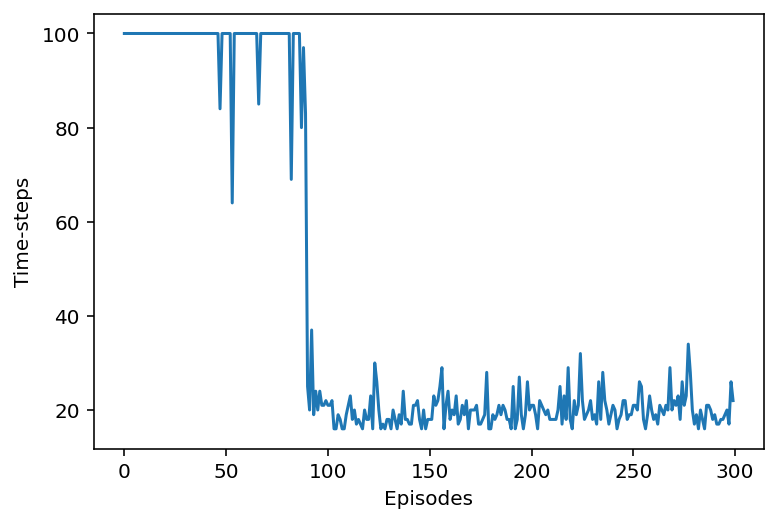

In [13]:
agent = TDSR(
    env.state_size,
    env.action_space.n,
    lr=1e-1,
    poltype="egreedy",
    epsilon=0.2,
    gamma=0.9,
)

total_steps = []
for i in range(num_episodes):
    agent, steps, returns = run_episode(env, agent, max_steps=num_steps)
    total_steps.append(steps)
plt.plot(total_steps)
plt.xlabel("Episodes")
plt.ylabel("Time-steps")

### Changing the reward locations

The `reward_locs` argument can be passed to `GridEnv` on reset in order to change the location and value of the rewards in the environment. This takes the form of a dictionary, where the keys are tuples corresponding to the x,y location in the grid, and the values are the rewards. Note that a reward of `1.0` or `-1.0` is interpreted to be a terminating state, and will send the `done` flag to the agent.

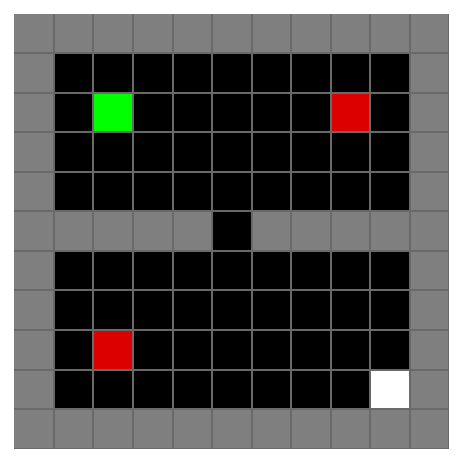

Text(0, 0.5, 'Time-steps')

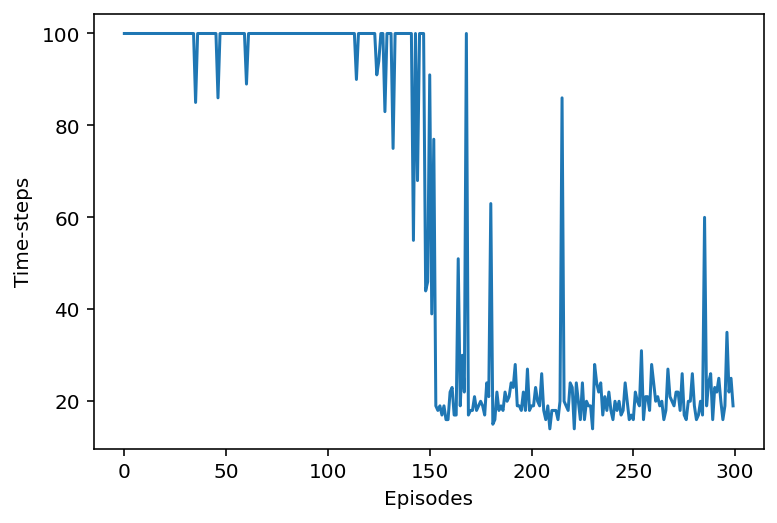

In [14]:
num_episodes = 300
num_steps = 100

env = GridEnv(
    topography=GridTopography.two_rooms,
    grid_size=GridSize.small,
    obs_type=GridObsType.index,
    orientation_type=OrientationType.fixed,
)

reward_map = {(2, 2): 1.0, (2, 8): -0.75, (8, 2): -0.75}

obs = env.reset(reward_locs=reward_map)
env.render()

agent = TDSR(
    env.state_size,
    env.action_space.n,
    lr=1e-2,
    poltype="egreedy",
    epsilon=0.2,
    gamma=0.9,
)

total_steps = []
for i in range(num_episodes):
    agent, steps, _ = run_episode(
        env, agent, max_steps=num_steps, reward_locs=reward_map
    )
    total_steps.append(steps)
plt.plot(total_steps)
plt.xlabel("Episodes")
plt.ylabel("Time-steps")

## Using the `GraphEnv`

For information on supported environment structures and observation spaces, see [here](https://github.com/awjuliani/neuro-nav/tree/main/neuronav/envs#graphenv).

/Users/ajuliani1/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


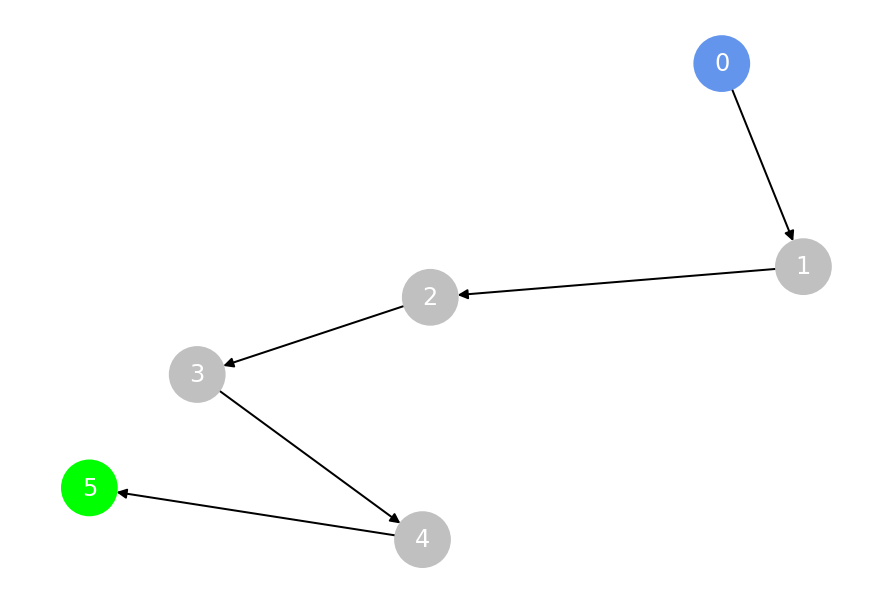

In [15]:
env = GraphEnv()
env.reset()
env.render()

### Selecting a different graph structure

The graph structure can be set with the `GraphStructure` enum.

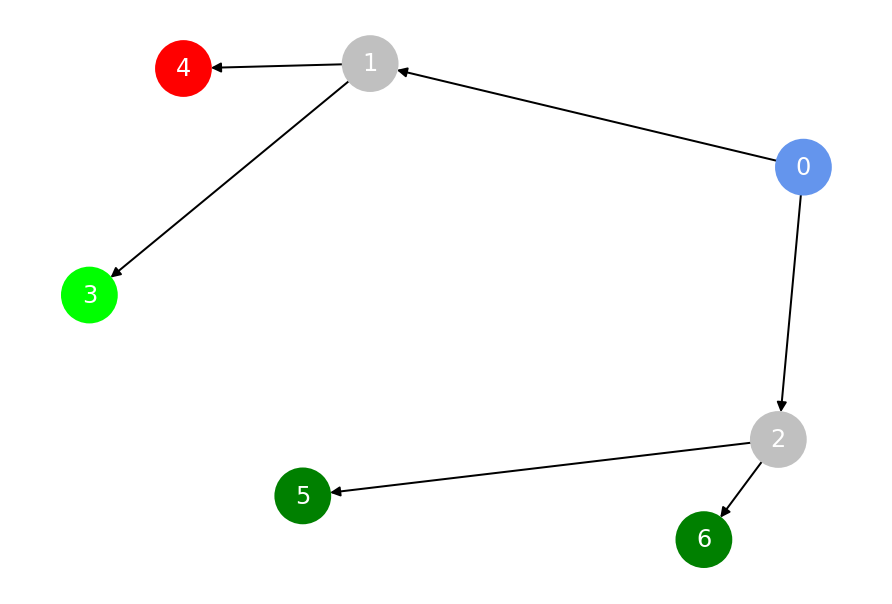

In [16]:
env = GraphEnv(graph_structure=GraphStructure.two_step)
obs = env.reset()
env.render()

### Training an agent to reach the goal

Text(0, 0.5, 'Returns')

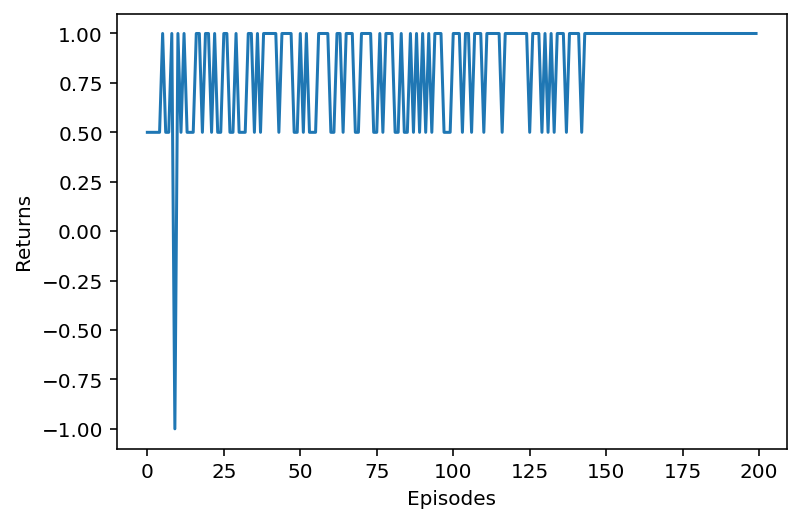

In [17]:
num_episodes = 200
num_steps = 25

agent = TDQ(env.state_size, env.action_space.n, lr=1e-3, poltype="softmax", beta=1e3)

total_returns = []
for i in range(num_episodes):
    agent, steps, returns = run_episode(env, agent, max_steps=num_steps)
    total_returns.append(returns)
plt.plot(total_returns)
plt.xlabel("Episodes")
plt.ylabel("Returns")